# Data Challenge: Large Scale Machine Learning (Report) 
                Author: Liliane MANITCHOKO

## Image Classification:

Image classification is the task of assigning to an image a label from a predefined set of
categories. A CNN [1] is intended to identify visual forms from images with least computation [2]. In the last few years, we saw a rapid progress in visual image processing systems, mostly due to advances of deep convolutional neural networks.



1. Y. LeCun, L. Bottu, Y. Bengio, Gradient-based learning applied to document recognition, Proceedings of the
IEEE 86 (11) (1998) 2278–2324, https://doi.org/10.1109/5.726791.
2. Alex Krizhevsky, Ilya Sutskever, Geoffrey E. Hinton, Imagenet classification with deep convolutional neural net-works, in: NIPS’12 Proceedings of the 25th InternationalConference on Neural Information ProcessingSystem,
vol. 1, 2012, pp. 1097–1105, arXiv:1311.2901.

## The properties of the dataset:

The data set is provided by IDEMIA, a multinational security company with headquaters in France. It consistst of images of faces of different persons with certain characteristics. The task is to train a model able to predict whether certain image possess required chacteristics (encoded by the output labels) or not.
There is imbalance between the sample images in the dataset for men and women.

### Downloading the Data: 

You can download the Dataset from the below link: 
https://partage.imt.fr/index.php/s/MQBgK6fkB8oyWA9

After unzipping the file, you have two folders: train, test and one text files relating to the train labels. You can use training images for training your model.

### Training Data

***Training Data:*** The "train" folder contains 192,576 face images numbered from 000000 to 192,575. These are color images in .jpg format with size of 80x80 pixels.

***Training Labels:*** The file named "label_train.txt" contains three columns. The first column containts the image name and the 2nd column lists the 192,576 labels (-1 or 1) that are used to train your model. The third columns lists the corresponding binary representation of genders (-1: woman, 1: Man)

### Test Data

 The "test" folder contains 9,999 face images numbered from 000000 to 009998. These are color images in .jpg format with size of 80x80 pixels.

### Remarks

 Image classification with certian unknown characteristics are difficult task. The purpose of this data challenge is to train the students to extract different characteristicts from images. So, it is important that at the end of the data challenge, you know the characteristics of the images on which this dataset is based on.

### The Performance Criterion:

You should submit a file that contains in each row classificaiton of images available in **test** folder. For a sample submission please see the codes below. 
To measure the performance of your model, we calculate two parameters.

1- Global Classification Performance  

2- Absolute_value(Classification_Performance_Men - Classification_Performance_Women)

The final metric is then the average classification accuracy for men and women, to which we substractthe difference of classification accuracy between men and women. 
$$ mean(accuracy_{men}, accuracy_{women}) - abs(accuracy_{men} - accuracy_{women})$$

### Import librairies

In [ ]:
# for data augmentation
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/123.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.5 MB/s eta 0:00:00
albumentations==1.3.0 is successfully installed


In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Sampler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score


import matplotlib.image as img
import numpy as np
import cv2 as cv

import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
os.getcwd()

%matplotlib inline

### Data loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False
if IN_COLAB:
  print("Colab started")
  mount='/content/gdrive/'
  print("Colab: mounting Google drive on ", mount)
  drive.mount(mount, force_remount=True)

Colab started
Colab: mounting Google drive on  /content/gdrive/
Mounted at /content/gdrive/


In [ ]:
!unzip '/content/gdrive/MyDrive/Data_challenge/data_challenge_Avril_2023.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/111437.jpg        
  inflating: train/111498.jpg        
  inflating: train/111524.jpg        
  inflating: train/111539.jpg        
  inflating: train/112107.jpg        
  inflating: train/112181.jpg        
  inflating: train/112325.jpg        
  inflating: train/112660.jpg        
  inflating: train/112887.jpg        
  inflating: train/113338.jpg        
  inflating: train/113403.jpg        
  inflating: train/113636.jpg        
  inflating: train/113710.jpg        
  inflating: train/113747.jpg        
  inflating: train/113969.jpg        
  inflating: train/114133.jpg        
  inflating: train/114827.jpg        
  inflating: train/115031.jpg        
  inflating: train/115119.jpg        
  inflating: train/115658.jpg        
  inflating: train/116060.jpg        
  inflating: train/116096.jpg        
  inflating: train/116107.jpg        
  inflating: train/116125.jpg        
  inflatin

### Import training data

In [ ]:
labels = pd.read_csv('/content/train.txt', sep = '\t', header = None, names = ['image','label', 'genre'])
labels = labels.astype({"label": int, "genre": int})
labels['label'] = labels['label'].map(lambda x: 0 if x == -1 else x)
labels['genre'] = labels['genre'].map(lambda x: 0 if x == -1 else x)
print(labels['label'].value_counts()/len(labels))

train_path = '/content/train/'

test_path = '/content/test/'

0    0.807136
1    0.192864
Name: label, dtype: float64


 We observed that there is an imbalance between classes (81% images without characteristics and 19% images with characteristics) that will be taking into account in the definition of lost function (below)

In [ ]:
print(labels['genre'].value_counts()/len(labels))

0    0.587581
1    0.412419
Name: genre, dtype: float64


There are 59% of women's images and 41% of men's images.

### Import and arrange test data

In [ ]:
import glob
frame = glob.glob('/content/test/*')
len(frame)

9999

In [ ]:
submission = pd.DataFrame(data = {'image' : [frame[i][-10:] for i in range(0,len(frame))]}).sort_values('image').reset_index(drop = True)

In [ ]:
# test data
submission.tail()

,image
9994,009994.jpg
9995,009995.jpg
9996,009996.jpg
9997,009997.jpg
9998,009998.jpg


### Exploration of training data

In [ ]:
# training data
labels.tail()

,image,label,genre
192571,192571.jpg,1,1
192572,192572.jpg,0,1
192573,192573.jpg,0,0
192574,192574.jpg,0,1
192575,192575.jpg,0,0


In [ ]:

img_1 = cv.imread('/content/train/000003.jpg')
print('shape of the image {}'.format(img_1.shape))
print('Value of the pixel {}'.format(img_1[40,40]))

shape of the image (80, 80, 3)
Value of the pixel [ 61  82 133]


#### Function to display images

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

#### Display some images with characteristics (label=1)

192546.jpg
192554.jpg
192558.jpg
192563.jpg
192571.jpg


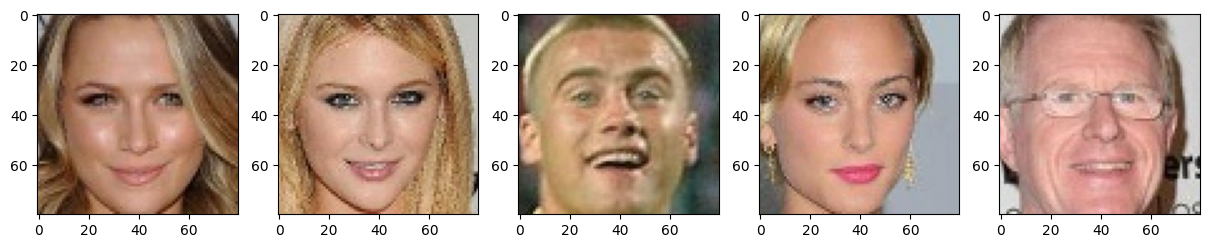

In [ ]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['label'] == 1]['image'][-5:]):
    print(idx)

    path = os.path.join(train_path,idx)

    ax[i].imshow(img.imread(path))

#### Display some images without characteristics (label=0)

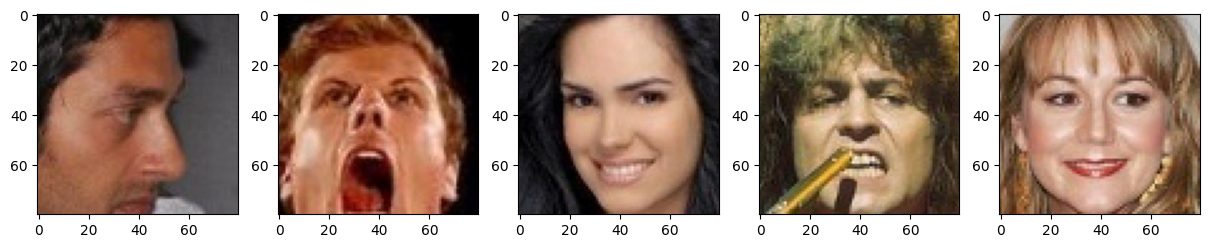

In [ ]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['label'] == 0]['image'][-5:]):

    path = os.path.join(train_path,idx)

    ax[i].imshow(img.imread(path))

In [ ]:
# Proportion of images with and without characteristics among mens
labels_men = labels[labels['genre'] == 1]
print(labels_men['label'].value_counts()/len(labels_men))


0    0.880461
1    0.119539
Name: label, dtype: float64


192419.jpg
192437.jpg
192452.jpg
192471.jpg
192481.jpg
192489.jpg
192491.jpg
192521.jpg
192558.jpg
192571.jpg


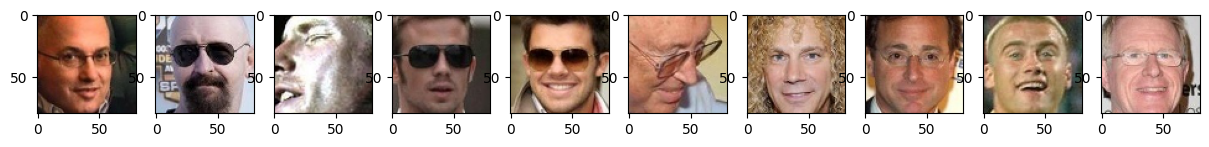

In [ ]:
# Display images of mens with characteristics
id_men = 1
id_label = 1
fig,ax = plt.subplots(1,10,figsize = (15,3))
for i,idx in enumerate(labels[(labels['label'] == id_label) & (labels['genre'] == id_men)]['image'][-10:]):
    print(idx)

    path = os.path.join(train_path,idx)

    ax[i].imshow(img.imread(path))

192551.jpg
192553.jpg
192555.jpg
192556.jpg
192560.jpg
192561.jpg
192565.jpg
192570.jpg
192572.jpg
192574.jpg


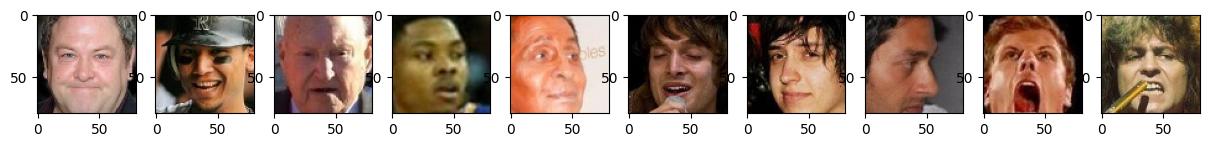

In [ ]:
# Display images of mens without characteristics
id_men = 1
id_label = 0
fig,ax = plt.subplots(1,10,figsize = (15,3))
for i,idx in enumerate(labels[(labels['label'] == id_label) & (labels['genre'] == id_men)]['image'][-10:]):
    print(idx)

    path = os.path.join(train_path,idx)

    ax[i].imshow(img.imread(path))

In [ ]:
# Proportion of images with and without characteristics among men and women
print(labels['label'].value_counts()/len(labels))
labels.groupby(['label','genre']).count()/len(labels)

0    0.807136
1    0.192864
Name: label, dtype: float64


image
label genre          
0     0      0.444017
      1      0.363119
1     0      0.143564
      1      0.049300

In [ ]:
# Proportion of images for men and women among images with characteristics (representing 19% of all images)
labels_with_charac = labels[labels['label'] == 1]
print(labels_with_charac['genre'].value_counts()/len(labels__with_charac))

0    0.74438
1    0.25562
Name: genre, dtype: float64


In [ ]:
# Proportion of images for men and women among images without characteristics (representing 81% of all images)
labels__without_charac = labels[labels['label'] == 0]
print(labels__without_charac['genre'].value_counts()/len(labels__without_charac))

0    0.550114
1    0.449886
Name: genre, dtype: float64


After this exploration of training dataset, we observed that there is an imbalance between classes (81% images without characteristics and 19% images with characteristics) that will be taking into account in the definition of lost function (below).

We also observed that many images with characteristics are images of women (14% vs 5% for images of men)

### Definition of 'CactiDataset_lbl' class that returns transformed images and their label 
This class takes data (training data), reads each image, transforms it (using an attribute which will be specified below)  and returns transformed image and its label.

In [ ]:
# class that returns transformed images and their label
class CactiDataset_lbl(Dataset):
    def __init__(self, data, path, transform=None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name, label, _ = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)

        if self.transform is not None:
            image = self.transform(image=image)

        return image, label

### Specification of image transformations for training data and validation data

 Image transformations for training data: code below is inspired by an example in the 'albumentations' package documentation.
We used this code to do multiple Random transformations of each image in training data: with the aim of having different representation of an image from one epoch to the next, giving the impression of training our model on different images from one epoch to the next: this is data augmentation.

In [ ]:
# Transformation of images for training data: code below inspired by an example in the 'albumentations' package documentation
train_transform = A.Compose([
    #A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),  # Set flip_limit to 0 for Horizontal flip only
    #A.Transpose(),
    A.OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=25, p=0.2),
    A.OneOf([ ##takes many time to run
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=.1), 
        A.IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.IAASharpen(),
        A.IAAEmboss(),
        A.RandomBrightnessContrast(),            
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
    ToTensorV2()
])


# Transformation of images for validation data: tranformation only to tensors
valid_transform = A.Compose([ToTensorV2()])


# Transformation of images to do visualization: retrieve transformation to tensor
train_transform_visu = A.Compose([
    #A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),  # Set flip_limit to 0 for Horizontal flip only
    #A.Transpose(),
    A.OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=25, p=0.2),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=.1),
        A.IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.IAASharpen(),
        A.IAAEmboss(),
        A.RandomBrightnessContrast(),            
    ], p=0.3),
    A.HueSaturationValue(p=0.3)
    #ToTensorV2()
])


#### Display some images with characteristics (label=1) after transformations

192546.jpg
192554.jpg
192558.jpg
192563.jpg
192571.jpg


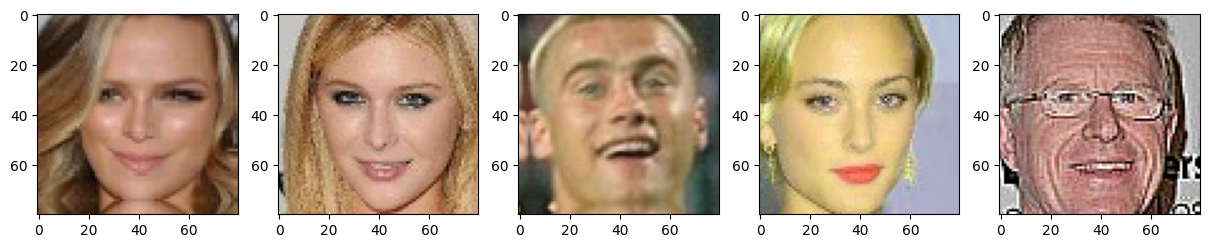

In [ ]:

fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i, idx in enumerate(labels[labels['label'] == 1]['image'][-5:]):
    print(idx)
    path = os.path.join(train_path, idx)
    image = img.imread(path)
    ax[i].imshow(train_transform_visu(image=image)['image'])

plt.show()


### Training and validate data

#### Select data for women only and split it in training and validate datasets

For the rest, we will use data for women only because as we could see above, among the 19% of images with characteristics, 14% are images of women. Images of women can thus be sufficient to detect whether or not there are characteristics in an image.

In fact, by using all the data in the previous attempts to train our model, we found that the characteristic prediction score for the men's images was always better (with a considerable difference) than the characteristic prediction score for the women's images. As the definition of the final score shows that the two scores for men and women must be very close, we then use only the women's data in order to improve their score (knowing that in all cases the men's score will be sufficiently high as there are very few images of men with the characteristics).

In [ ]:
# seleted women
labels_women = labels[labels['genre'] == 0]
#labels_women = labels
train_women, valid_data_df_women = train_test_split(labels_women , stratify=labels_women.label, test_size=0.2)


In [ ]:
valid_data_df_women.head()

,image,label,genre
108400,108400.jpg,0,0
41775,041775.jpg,1,0
36801,036801.jpg,0,0
79821,079821.jpg,0,0
149529,149529.jpg,0,0


In [ ]:
train_women.head()

,image,label,genre
77416,077416.jpg,1,0
72342,072342.jpg,0,0
69133,069133.jpg,0,0
91991,091991.jpg,1,0
27507,027507.jpg,0,0


#### Apply CactiDataset_lbl class to training and validate datas for women

In [ ]:
train_data_women = CactiDataset_lbl(train_women, train_path, transform = train_transform)
valid_data_women = CactiDataset_lbl(valid_data_df_women, train_path, transform = valid_transform )


### Model specification

In [ ]:
# Fixed hyper parameters values
num_epochs = 7
num_classes = 2
batch_size = 50
batch_size_val = 1
learning_rate = 0.001

In [ ]:
# CPU or GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
# Create the batches (data samples of size batch_size = 50) to be used for calculating the SGD: stochastic gradient descent (in the learning loop)
train_loader = DataLoader(dataset = train_data_women, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data_women, batch_size = batch_size_val, shuffle=False, num_workers=0)


#### First neural network used

We modified the basic network provided by adding a convolution layer conv3

In [ ]:
# Modification of the basic network provided by adding a convolution layer conv3
class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3) # 
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        #self.fc1 = nn.Linear(6480, 1024)
        self.fc1 = nn.Linear(640, 25)
        #self.fc1_drop = nn.Dropout(p=0.2)  # Add Dropout after fc1
        #self.fc2 = nn.Linear(1024, 2)
        self.fc2 = nn.Linear(25, 2)

    def forward(self, x):
      # [ nn.Conv2d --> nn.BatchNorm2d --> nn.ReLU ] * N  --> nn.MaxPool2d
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        #x = self.fc1_drop(x)  # Apply dropout after fc1
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

#### Second neural network used

We defined a new architecture of cnn

In [ ]:
# New architecture

def conv_block(input_features, output_features):
    seq = nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=3),
        nn.BatchNorm2d(output_features), #normalisation/régularisation
        nn.ReLU(inplace=True)
    )
    return seq

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.maxpool2d = nn.MaxPool2d(2, 2)
        self.conv_block_1 = conv_block(3, 16)
        self.conv_block_2 = conv_block(16, 16)
        self.conv_block_3 = conv_block(16, 32)
        self.conv_block_4 = conv_block(32, 32)
        self.conv_block_5 = conv_block(32, 64)
        self.conv_block_6 = conv_block(64, 64)
        self.conv_block_6 = conv_block(64, 92)
        self.conv_block_7 = conv_block(92, 92)
        self.conv_block_8 = conv_block(92, 124)

        self.fc1 = nn.Linear(124 , 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.maxpool2d(x)

        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.maxpool2d(x)

        x = self.conv_block_5(x)
        x = self.conv_block_6(x)
        x = self.maxpool2d(x)

        x = self.conv_block_7(x)
        x = self.conv_block_8(x)
        x = self.maxpool2d(x)

        x = x.view(x.shape[0], -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = F.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
sample = CNN()
print(sample)

CNN(
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block_4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block_5): Sequential(
    (0): Conv2d(32, 64, kernel_size=

#### Third neural network used

We used a pre-trained neural network called resnet18. It was with this network that we obtained our latest and best results, presented below.

In [ ]:
# Obtain pre-trained neural network resnet18 and display its structure
pretrained_net = models.resnet18(pretrained=True)
print(net)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.7MB/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (resnet_block1): Sequential(
    (0): Residual(
      (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): LazyConv2d(0, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resnet_

In [ ]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

#### Finetuning the pre-trained neural network by using the learning rate

In [ ]:
%%time

# Create the ResNet-18 model
finetune_net = models.resnet18(pretrained=True)

# Replace the last fully connected layer (number of output neurons = 2 for 2 classes)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)

# Specify different learning rates for the last layer and the rest of the layers
learning_rate_last_layer = learning_rate
learning_rate_other_layers = learning_rate/10  #(pr avoir un learning rate très faible pour les premières couches afin d'extraire toutes les caractéristiques des images données à l'entrée du réseau)
# resserer le learning rate des premières couches pour que le réseau pré-entrainé s'adapte mieux à nos données

# Define the parameters and learning rates for each parameter group
parameters = [
    {"params": finetune_net.fc.parameters(), "lr": learning_rate_last_layer},
    {"params": [param for name, param in finetune_net.named_parameters() if name != "fc.weight" and name != "fc.bias"], "lr": learning_rate_other_layers}
]

# Create an Adam optimizer with the specified learning rates for different parameter groups
optimizer = torch.optim.Adam(parameters, lr=0)  # lr=0 since we'll specify learning rates per group

# Create a CosineAnnealingLR learning rate scheduler
# chaque epoch permet d'améliorer l'optimisation (en mettant à jour les poids). La difference entre chaque epoch est les images contenus dans les batch. Dans notre cas, même les images d'entrée du réseau dans chaque epoch peuvent être differentes car on applique des tranformations aléatoires aux données
# Plus le nombre d'epoch augmente, plus il devient difficile d'améliorer l'optimisation (car l'avancement dans les epochs améliore déjà l'optimisation). Pour améliorer l'optim dans ce cas, il faut réduire le learning rate au fur et à mesure que le nbre d'epoch augmente
# scheduler obtenu avec CosineAnnealingLR: Pour réduire le learning rate au fur et à mesure qu'on avance dans les epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


model = finetune_net
model = model.to(device)


# Define the weights for the loss function (to resolve imbalance problem)
weight_without_charac = 0.2  # Example weight for image 'without characteristic'
weight_with_charac = 0.8   # Example weight for image 'with characteristics'

# Define the loss function with weights
criterion = nn.CrossEntropyLoss(weight=torch.tensor([weight_without_charac, weight_with_charac])).to(device)



CPU times: user 324 ms, sys: 65.4 ms, total: 390 ms
Wall time: 405 ms


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training and validate loop on batches (train_loader) of training data and on batches (valid_loader) of validate data

In [ ]:
%%time
swa_model = torch.optim.swa_utils.AveragedModel(model)
swa_scheduler = torch.optim.swa_utils.SWALR(optimizer, swa_lr=0.001)
swa_start = 10

# keeping-track-of-losses
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data['image'].to(device).float()
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        
        # calculate-the-batch-loss
        loss = criterion(output, target)
        
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        
        # update-training-loss
        train_loss += loss.item() * data.size(0)
    
    # validate-the-model
    model.eval()

    for data, target in valid_loader:
        data = data['image'].to(device).float()
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)

    # calculate-average-losses
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print-training/validation-statistics 
    print('Epoch: {}\tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # Update SWA model and scheduler after swa_start epochs (update learning rate at the end of one epoch)
    # scheduler.step()

    if epoch > swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
    else:
        scheduler.step() # update learning rate at the end of one epoch


Epoch: 1	Training Loss: 0.249502	Validation Loss: 0.248719
Epoch: 2	Training Loss: 0.209280	Validation Loss: 0.194354
Epoch: 3	Training Loss: 0.198486	Validation Loss: 0.243017
Epoch: 4	Training Loss: 0.184459	Validation Loss: 0.199808
Epoch: 5	Training Loss: 0.172968	Validation Loss: 0.193548
Epoch: 6	Training Loss: 0.160471	Validation Loss: 0.191337
Epoch: 7	Training Loss: 0.153877	Validation Loss: 0.180567
CPU times: user 1h 25min 58s, sys: 1h 35min 45s, total: 3h 1min 43s
Wall time: 1h 57min 45s


#### Prediction on batches (valid_loader) of validate data

In [ ]:
val_pred_values = []
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, actual_labels in valid_loader:
        images = images['image'].to(device).float()
        actual_labels = actual_labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_pred_values.append(predicted.item())
        #print(predicted.item())
        #total += actual_labels.size(0)
        #correct += (predicted == actual_labels).sum().item()
        #print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 

torch.save(model.state_dict(), 'model.ckpt')

In [ ]:
len(val_pred_values)

22631

In [ ]:
valid_data_df_women['score'] = np.array(val_pred_values)
group_by_genre = valid_data_df_women.groupby('genre')
#genre_0, genre_1= [group_by_genre.get_group(x) for x in group_by_genre.groups]
genre_0, = [group_by_genre.get_group(x) for x in group_by_genre.groups]
genre_0

,image,label,genre,score
108400,108400.jpg,0,0,0
41775,041775.jpg,1,0,1
36801,036801.jpg,0,0,1
79821,079821.jpg,0,0,0
149529,149529.jpg,0,0,0
...,...,...,...,...
43409,043409.jpg,0,0,0
54280,054280.jpg,0,0,0
47677,047677.jpg,1,0,1
94009,094009.jpg,1,0,1


041775.jpg
036801.jpg
145781.jpg
013886.jpg
090542.jpg


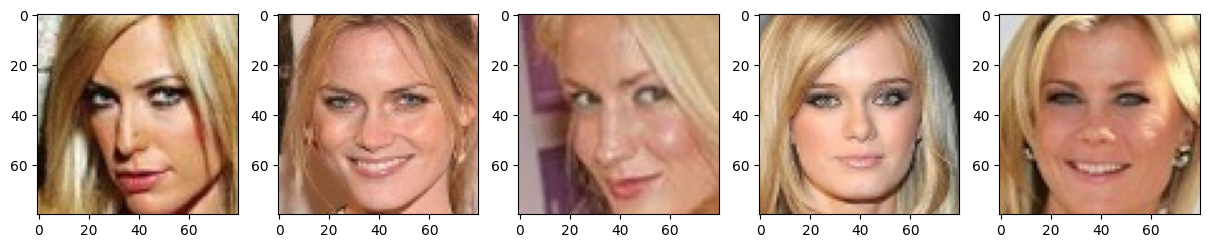

In [ ]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(genre_0[genre_0['score'] == 1]['image'][:5]):
    print(idx)

    path = os.path.join(train_path,idx)

    ax[i].imshow(img.imread(path))

In [ ]:
print('Accuracy_score: ' , accuracy_score(valid_data_df_women['label'], valid_data_df_women['score']))
print('Accuracy_score genre_0: ' , accuracy_score(genre_0['label'], genre_0['score']))

#print('Accuracy_score genre_1: ' , accuracy_score(genre_1['label'], genre_1['score']))

Accuracy_score:  0.9266050992002121
Accuracy_score genre_0:  0.9266050992002121


In [ ]:
#Score used for ranking the submission 
score_0 =  accuracy_score(genre_0['label'], genre_0['score'])
#score_1 =  accuracy_score(genre_1['label'], genre_1['score'])
#print('Final_score:', (score_0+score_1)/2 - abs(score_0-score_1))

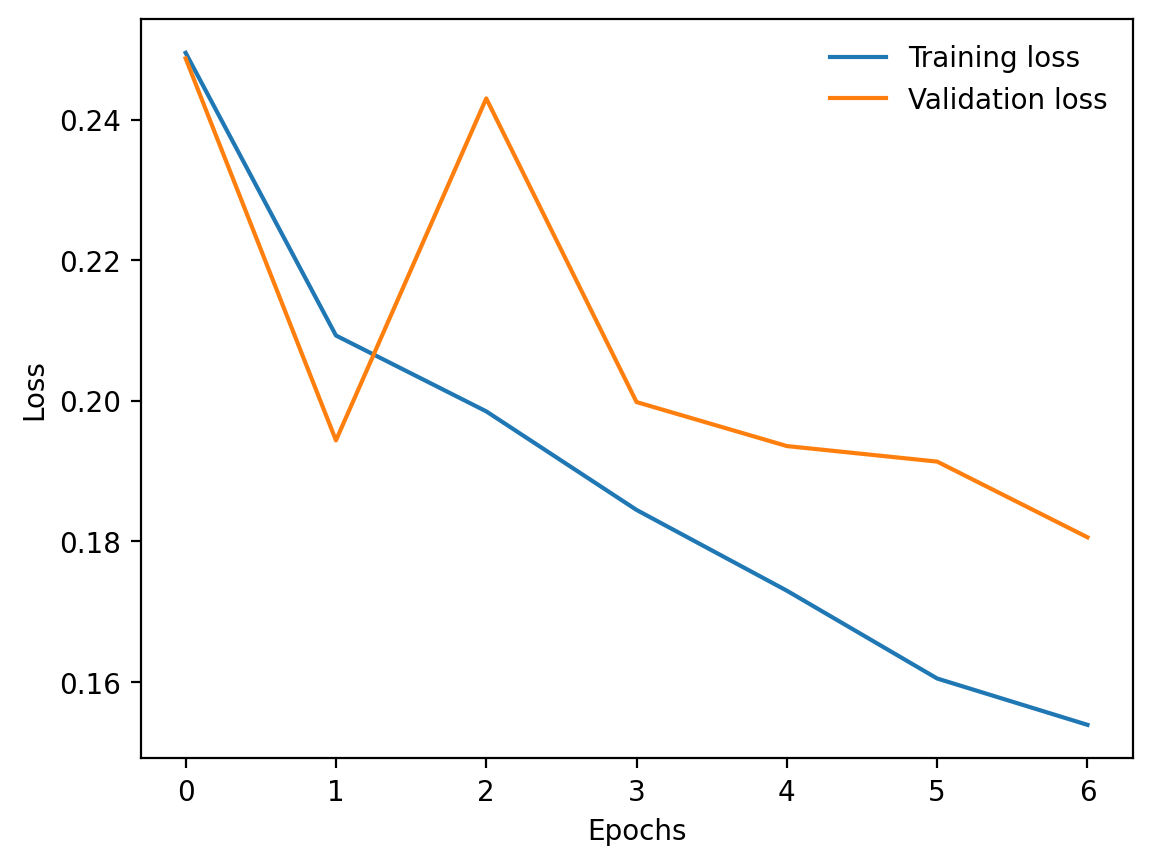

In [ ]:
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

### Testing our Model (trained on women data only) on all test data (for men and women)

In [ ]:
batch_size_test = 1

class Dataset_test(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values.flatten()
        # print(self.data)
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
        img_name = self.data[index]
        img_path = os.path.join(self.path, str(img_name))
        # print(img_path)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image = image)
        return image
    

test_transform = A.Compose([ToTensorV2()])

test_data = Dataset_test(submission, test_path, test_transform )
test_loader = DataLoader(dataset = test_data, batch_size = batch_size_test, shuffle=False, num_workers=0)

In [ ]:
# test-the-model

model.eval()  # it-disables-dropout
predicted_values = []
with torch.no_grad():
    for images in test_loader:
        #images = images.to(device)
        images = images['image'].to(device).float()
        # labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        # print(predicted.item())
        predicted_values.append(predicted.item())

In [ ]:
print(len(predicted_values))
predicted_values[:14]

9999


[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]

### Preparing our file for Submission

In [ ]:
results=pd.DataFrame(predicted_values, columns= ['score'])
results['score'] = results['score'].map(lambda x: -1 if x == 0 else x)
results.to_csv("Data_Challenge_MDI_341.csv", header = None, index = None)

This obtained submission file gives us (on the data challenge platform): 

Gender_0_Accuracy= 0.9416

Gender_1_Accuracy= 0.929385877175

Final_Score = 0.923278815763